## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
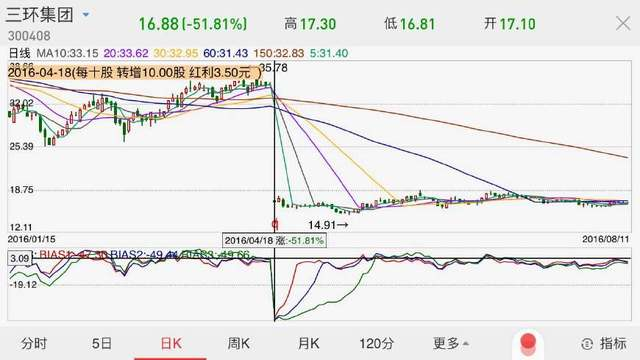

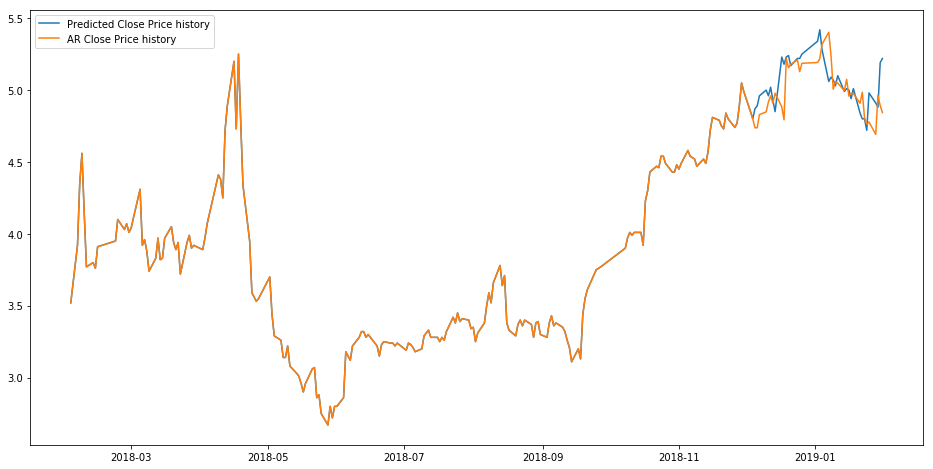

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob # Filename globbing utility
import os
import matplotlib.pyplot as plt


def find_files(path):
    # Return a list of paths matching a pathname pattern.
    return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [2]:
import unicodedata # unicode character database access
import string # A collection of string constants

# string.ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    # 将输入字符串进行标准化，之后遍历每个字符，
    # 找出一般类型等于Mn(Nonspacing_Mark)，
    # 且存在于all_letters列表中的字符，
    # 拼接起来并返回
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' # Returns the general category assigned to the character
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    # basename 获取文件名（去掉路径内容）; splitext 将文件名拆分成名称和扩展名，[0]取第一项，即名称
    category = os.path.splitext(os.path.basename(filename))[0] 
    all_categories.append(category) # 记录类别
    lines = read_lines(filename) # 读取数据
    category_lines[category] = lines # 记录 类别 - 数据 对

n_categories = len(all_categories)

In [12]:
n_categories

18

In [13]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [14]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    # one-hot alike
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [15]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

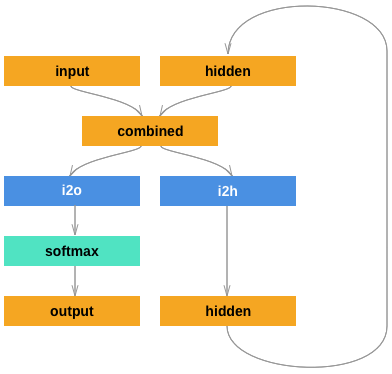

In [23]:
import torch.nn as nn

class RNN(nn.Module): # 继承Module类
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__() # 调用父类init方法

        self.hidden_size = hidden_size
        
        # nn.Linear参数(input_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # 添加input到hidden state的线性计算
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # 添加input到output的线性计算
        self.softmax = nn.LogSoftmax(dim=1) # 添加激活函数，对softmax结果取对数，dim为待计算的对应维度

    def forward(self, input, hidden):
        # 前向传播
        combined = torch.cat((input, hidden), 1) # 拼接当前input和上一时刻的hidden state
        hidden = self.i2h(combined) # 计算当前hidden state
        output = self.i2o(combined) # 计算当前output logit
        output = self.softmax(output) # 对output logit 施加激活函数
        return output, hidden

    def initHidden(self):
        # 全零初始化 0 时刻的 hidden state
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [24]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [25]:
input = letter_to_tensor('A') # 输入数据
hidden = rnn.initHidden() # 初始化hidden state

output, next_hidden = rnn(input, hidden)# 直接调用对象，会调用forward函数

In [26]:
output

tensor([[-2.8217, -2.9509, -2.9652, -2.9526, -2.8198, -2.9777, -2.7941, -2.8910,
         -2.8175, -2.9177, -2.8936, -3.0032, -2.8498, -2.8844, -2.8716, -2.8501,
         -2.9031, -2.8937]], grad_fn=<LogSoftmaxBackward>)

In [27]:
next_hidden

tensor([[-0.0102, -0.0313,  0.0435,  0.0193, -0.0242, -0.1040,  0.0653, -0.0940,
          0.0481, -0.1389,  0.0998,  0.0188, -0.0701,  0.0176, -0.0856,  0.0323,
         -0.0070,  0.0435,  0.0184,  0.0897,  0.0943, -0.0407,  0.0017,  0.0142,
          0.0699,  0.0665, -0.0444, -0.1029, -0.0156, -0.0321, -0.0277, -0.0952,
         -0.0057, -0.0504,  0.0020, -0.0577, -0.0019,  0.1061,  0.0009,  0.0960,
         -0.1095, -0.0562,  0.0599,  0.0975,  0.0023, -0.0438, -0.0591, -0.0261,
          0.0189, -0.0113, -0.0592,  0.0011,  0.0034, -0.0163,  0.0045,  0.0024,
         -0.0628,  0.0118,  0.0594, -0.0214,  0.0470,  0.0423,  0.0293, -0.0009,
         -0.0591,  0.1134,  0.1158, -0.0243, -0.0698,  0.0595,  0.0712, -0.0869,
         -0.0210, -0.0314,  0.0262,  0.0922,  0.0807, -0.0052, -0.0925, -0.0258,
         -0.0863,  0.0311, -0.0084,  0.1105,  0.0635,  0.0281,  0.0938,  0.0725,
          0.1009, -0.1042, -0.0371, -0.0736, -0.1299,  0.0912,  0.0284, -0.1059,
          0.0063,  0.0068, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [28]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8217, -2.9509, -2.9652, -2.9526, -2.8198, -2.9777, -2.7941, -2.8910,
         -2.8175, -2.9177, -2.8936, -3.0032, -2.8498, -2.8844, -2.8716, -2.8501,
         -2.9031, -2.8937]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [43]:
def category_from_output(output):
    # 格式化输出
    top_n, top_i = output.topk(1) # 取出值最大的项目
#     print(top_n) # tensor([[-2.7941]], grad_fn=<TopkBackward>) 值
#     print(top_i) # tensor([[6]]) 索引
#     print(output)
    
    category_i = top_i[0].item() # 取出数据
    return all_categories[category_i], category_i # 从字典取出类别名称并返回名称和索引

对于刚刚产生的output，我们使用这个函数

In [32]:
print(category_from_output(output))

tensor([[-2.7941]], grad_fn=<TopkBackward>)
tensor([[6]])
tensor([[-2.8217, -2.9509, -2.9652, -2.9526, -2.8198, -2.9777, -2.7941, -2.8910,
         -2.8175, -2.9177, -2.8936, -3.0032, -2.8498, -2.8844, -2.8716, -2.8501,
         -2.9031, -2.8937]], grad_fn=<LogSoftmaxBackward>)
('German', 6)


### 1.8 随机生成训练数据

In [131]:
import random

def sample(l):
    # 随机取出一个元素
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    # 生成数据
    category = sample(all_categories) # 随机取出一个国籍
    line = sample(category_lines[category]) # 随机取出该国籍下的一个名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # 生成label tensor，list.index返回国籍索引
    line_tensor = line_to_tensor(line) # 生成input tensor
    return category, line, category_tensor, line_tensor

In [132]:
for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Magalhaes
category = Chinese / line = Mui
category = Czech / line = Dana
category = Spanish / line = Abasolo
category = Russian / line = Horujy
category = Greek / line = Metrofanis
category = German / line = Swango
category = Vietnamese / line = Chu
category = French / line = Mathieu
category = Dutch / line = Lucas


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [36]:
criterion = nn.CrossEntropyLoss()

In [41]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # 初始化hidden state

    rnn.zero_grad() # 将所有参数的梯度置为零

    for i in range(line_tensor.size()[0]): # torch.Size([n, 1, 57]), range(n)，遍历句子中每个字
        output, hidden = rnn(line_tensor[i], hidden) # 对每个字调用forward，获取输出，更新hidden state

    # 在一条数据完整输入后，进行损失计算和反向传播
    loss = criterion(output, category_tensor) # 计算交叉熵损失，传入output和label
    loss.backward() # 自动进行反向传播

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        # 向负梯度方向更新参数
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() # 返回最终输出

In [44]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    # 计算时间消耗
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time() # 初始时间

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning() # 随机生成一条数据
    output, loss = train(category_tensor, line_tensor) # 进行训练
    current_loss += loss # 叠加损失 #### 当前批次的损失，plot_every 相当于 batch size

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        # 打印当前训练结果
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        # 记录损失
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 1s) 1.7795 Kieu / Vietnamese ✓
1000 10% (0m 2s) 2.4936 Fields / Portuguese ✗ (English)
1500 15% (0m 3s) 1.0412 Tieu / Vietnamese ✓
2000 20% (0m 4s) 0.9564 Rudawski / Polish ✓
2500 25% (0m 5s) 2.4077 Dandy / Irish ✗ (English)
3000 30% (0m 6s) 1.2069 Mancini / Italian ✓
3500 35% (0m 7s) 2.1690 Herback / Italian ✗ (Czech)
4000 40% (0m 9s) 0.9366 Jigunov / Russian ✓
4500 45% (0m 10s) 3.3605 Zaloumi / Italian ✗ (Greek)
5000 50% (0m 11s) 2.6339 Paisar / Arabic ✗ (Czech)
5500 55% (0m 13s) 0.8584 Schneijders / Dutch ✓
6000 60% (0m 14s) 1.5553 Sowka / Czech ✗ (Polish)
6500 65% (0m 15s) 0.4810 Badykshanov / Russian ✓
7000 70% (0m 17s) 1.3715 Severins / Dutch ✓
7500 75% (0m 18s) 1.4817 Gudymenko / Polish ✗ (Russian)
8000 80% (0m 19s) 3.0771 Morcos / Portuguese ✗ (Arabic)
8500 85% (0m 21s) 2.8080 Wiater / Arabic ✗ (Polish)
9000 90% (0m 22s) 1.7209 Kwei / Vietnamese ✗ (Chinese)
9500 95% (0m 23s) 0.9965 Ding / Chinese ✓
10000 100% (0m 25s) 1.8345 Maria / Arabic ✗ (Portuguese)


### 1.9 观察Loss的变化

In [52]:
all_losses[::10]

[2.21724654763937,
 2.109525449872017,
 2.0163484627008437,
 2.1487765675783157,
 1.9274173349142074,
 1.8047184135764838,
 2.073047964721918,
 1.8455348928272723,
 1.921639445722103,
 1.8178584020584823]

In [53]:
%matplotlib inline

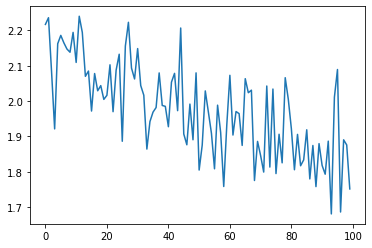

In [54]:
# 整体呈下降趋势，抖动剧烈
plt.plot(all_losses)

In [56]:
def evaluate(line_tensor):
    # 进行前向传播，获取结果，作为预测类别
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    # 获取预测可能性最高的n项
    print('\n> %s' % input_line)
    with torch.no_grad(): # 禁用梯度计算
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)# 前n项，排序维度，是否从大到小排序
        predictions = []

        # 取出结果并格式化输出
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.13) Polish
(-1.23) Russian
(-2.02) Czech

> Jackson
(-1.19) Scottish
(-1.60) Russian
(-2.30) Irish

> Satoshi
(-1.35) Japanese
(-1.47) Italian
(-2.14) Polish


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [277]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size[0]
        # 三个layer结构
        self.i2h_1 = nn.Linear(input_size + hidden_size[0], hidden_size[1])
        self.i2o_1 = nn.Linear(input_size + hidden_size[0], output_size[0])
        
        self.i2h_2 = nn.Linear(hidden_size[1], hidden_size[2])
        self.i2o_2 = nn.Linear(output_size[0], output_size[1])
        
        self.i2h_3 = nn.Linear(hidden_size[2], hidden_size[0])
        self.i2o_3 = nn.Linear(output_size[1], output_size[2])
        
        # 激活函数
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1) # 添加激活函数，对softmax结果取对数，dim为待计算的对应维度

    def forward(self, input, hidden):
        # 前向传播
        combined = torch.cat((input, hidden), 1) # 拼接当前input和上一时刻的hidden state
        # layer 1
        hidden = self.tanh(self.i2h_1(combined))
        output = self.tanh(self.i2o_1(combined))
        # layer 2
        hidden = self.tanh(self.i2h_2(hidden))
        output = self.tanh(self.i2o_2(output))
        # layer 3
        hidden = self.tanh(self.i2h_3(hidden))
        output = self.i2o_3(output)
        
        output = self.softmax(output) # 对output logit 施加激活函数
        return output, hidden

    def initHidden(self):
        # 全零初始化 0 时刻的 hidden state
        return torch.zeros(1, self.hidden_size)

#### 构建网络

In [278]:
n_hidden = [128, 256, 512]
n_output = [128, 256, n_categories]
rnn = RNN(n_letters, n_hidden, n_output)

In [279]:
print(rnn)

RNN(
  (i2h_1): Linear(in_features=185, out_features=256, bias=True)
  (i2o_1): Linear(in_features=185, out_features=128, bias=True)
  (i2h_2): Linear(in_features=256, out_features=512, bias=True)
  (i2o_2): Linear(in_features=128, out_features=256, bias=True)
  (i2h_3): Linear(in_features=512, out_features=128, bias=True)
  (i2o_3): Linear(in_features=256, out_features=18, bias=True)
  (tanh): Tanh()
  (softmax): LogSoftmax()
)


#### 训练

In [280]:
n_iters = 10000
print_every = 500
plot_every = 100
learning_rate = 0.01 # 过大时(0.1)会导致loss变成nan

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time() # 初始时间

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning() # 随机生成一条数据
    output, loss = train(category_tensor, line_tensor) # 进行训练
    current_loss += loss # 叠加损失

    if iter % print_every == 0:
        # 打印当前训练结果
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        # 记录损失
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 4s) 2.7962 Gagne / Spanish ✗ (French)
1000 10% (0m 9s) 2.8986 Nussenbaum / Korean ✗ (German)
1500 15% (0m 13s) 2.9172 Nifterick / Spanish ✗ (Dutch)
2000 20% (0m 17s) 2.0630 Demakis / Greek ✓
2500 25% (0m 22s) 3.0323 Mas / Greek ✗ (Spanish)
3000 30% (0m 27s) 2.9791 St martin / Irish ✗ (French)
3500 35% (0m 33s) 2.8536 Mateus / Greek ✗ (Portuguese)
4000 40% (0m 38s) 2.6902 Ritchie / French ✗ (Scottish)
4500 45% (0m 44s) 2.9607 Bartosz / Czech ✗ (Polish)
5000 50% (0m 49s) 2.2095 Rovnyansky / Russian ✓
5500 55% (0m 54s) 2.6034 Essop / German ✗ (English)
6000 60% (1m 0s) 2.6231 Khouri / Japanese ✗ (Arabic)
6500 65% (1m 5s) 2.3673 Rooiakker / German ✗ (Dutch)
7000 70% (1m 11s) 1.7956 Zhai / Italian ✗ (Chinese)
7500 75% (1m 16s) 2.9936 Opp / Vietnamese ✗ (Czech)
8000 80% (1m 21s) 1.6926 Emile / French ✓
8500 85% (1m 27s) 1.8368 Thibault / French ✓
9000 90% (1m 32s) 0.7337 Petri / Italian ✓
9500 95% (1m 37s) 2.6038 Millar / German ✗ (Scottish)
10000 100% (1m 42s) 2.2550 Russell / En

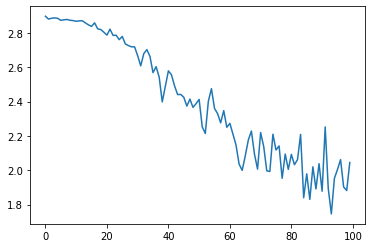

In [281]:
plt.plot(all_losses)

增加layer后，模型学习能力增强，loss比单层模型下降显著

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

### LSTM

In [282]:
class MultiLayer_LSTM(nn.Module):
    '''
    多层lstm模型
    '''
    def __init__(self, output_activation, criterion, input_size, hidden_size, output_size, num_layers=1):
        '''
        构造函数
        ----------
        output_activation: 输出层激活函数
        criterion： 损失函数
        input_size: 输入维度
        hidden_size: hidden state 和 cell state的维度
        output_size: 输出维度
        num_layers: lstm层数
        '''
        super(MultiLayer_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.output_activation = output_activation # o -> o
        self.criterion = criterion
        self.hidden_size = hidden_size
        
    def forward(self, input, hidden, cell):
        '''
        前向传播
        --------------
        input: 当前时刻的输入
        hidden: 前一时刻的hidden state
        cell: 前一时刻的cell state
        '''
        # 进行前向计算，更新hidden state 和 cell state，获取output
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        # 将最后的输出尺寸转换成output_size
        output = self.i2o(output[-1])
        # 对输出施加激活
        output = self.output_activation(output)
        return output, hidden, cell

    def initHiddenAndCell(self):
        '''
        全零初始化 0 时刻的 hidden state 和 cell state
        '''
        return tuple(torch.zeros(2, 1, 1, self.hidden_size))
    
    def train_single_line(self, category_tensor, line_tensor, learning_rate=0.005):
        '''
        单步训练
        -----------
        category_tensor: label
        line_tensor: data
        learning_rate: 学习率
        '''
        hidden, cell = self.initHiddenAndCell() # 初始化hidden 和 cell

        self.zero_grad() # 将所有参数的梯度置为零

        # lin_tensor.size() = torch.Size([n, 1, 57])
        output, hidden, cell = self(line_tensor, hidden, cell) # 对输入调用forward，获取输出，hidden state和cell state

        # 进行损失计算和反向传播
        loss = self.criterion(output, category_tensor) # 计算损失，传入output和label
        loss.backward() # 自动进行反向传播

        for p in self.parameters():
            # 向负梯度方向更新参数
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item() # 返回最终输出
    
    def fit(self, n_iters = 10000, print_every = 500, plot_every = 100, learning_rate=0.1, lr_decay=None, verbose=1):
        '''
        训练模型
        -------------
        n_iters: 训练步数
        print_every: 打印过程信息的间隔（lr_decay不为None时，也作为学习率衰减的周期）
        plot_every: 记录平均损失的间隔
        learning_rate: 初始学习率
        lr_decay: 学习率衰减比例(0-1的float)，None为不使用
        verbose: 训练过程是否打印输出
        '''
        # Keep track of losses for plotting
        current_loss = 0
        all_losses = []

        start = time.time() # 初始时间

        for iter in range(1, n_iters + 1):
            category, line, category_tensor, line_tensor = sample_trainning() # 随机生成一条数据
            output, loss = self.train_single_line(category_tensor, line_tensor) # 进行训练
            current_loss += loss # 叠加损失

            if iter % print_every == 0:
                # 打印当前训练结果
                if verbose:
                    guess, guess_i = category_from_output(output)
                    correct = '✓' if guess == category else '✗ (%s)' % category
                    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))
                # 学习率衰减
                if lr_decay and lr_decay > 0 and lr_decay < 1:
                    learning_rate *= (1 - lr_decay)

            if iter % plot_every == 0:
                # 记录损失
                all_losses.append(current_loss / plot_every)
                current_loss = 0
        return all_losses

#### 构建网络

In [285]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)
# 选取损失函数
criterion = nn.CrossEntropyLoss()
# 实例化模型
# n_letters = 57
# n_categories = 18
h = 128 # hidden size
lstm = MultiLayer_LSTM(output_activation, criterion, n_letters, h, n_categories)
# 模型结构
print(lstm)

MultiLayer_LSTM(
  (lstm): LSTM(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (output_activation): LogSoftmax()
  (criterion): CrossEntropyLoss()
)


#### 训练 n_iters=1000

500 50% (0m 2s) 2.8752 Trieu / Polish ✗ (Vietnamese)
1000 100% (0m 4s) 2.9477 Lamar / Polish ✗ (French)


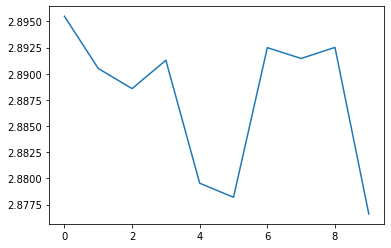

In [286]:
losses = lstm.fit(n_iters=1000)
plt.plot(losses)

结果秒出，训练严重不足，loss曲线一直震荡。

#### n_iters = 10000

500 5% (0m 2s) 2.7512 Bellerose / French ✓
1000 10% (0m 4s) 2.7800 Emelianenkov / French ✗ (Russian)
1500 15% (0m 6s) 2.9175 Letsos / Russian ✗ (Greek)
2000 20% (0m 8s) 2.8750 Albuquerque / French ✗ (Portuguese)
2500 25% (0m 10s) 2.8252 Boyle / Japanese ✗ (Scottish)
3000 30% (0m 13s) 2.8423 Antonopoulos / Japanese ✗ (Greek)
3500 35% (0m 16s) 2.9112 Romijn / French ✗ (Dutch)
4000 40% (0m 18s) 2.9151 Elliott / Japanese ✗ (English)
4500 45% (0m 21s) 3.0032 Adamczak / Japanese ✗ (Polish)
5000 50% (0m 25s) 2.8717 Chromy / Japanese ✗ (Czech)
5500 55% (0m 27s) 2.8658 Krantz / Vietnamese ✗ (German)
6000 60% (0m 30s) 2.9247 Morcos / Greek ✗ (Arabic)
6500 65% (0m 33s) 2.8909 Navratil / Greek ✗ (Czech)
7000 70% (0m 36s) 2.9907 Rompay / Greek ✗ (Dutch)
7500 75% (0m 38s) 2.8010 Dubrovin / Greek ✗ (Russian)
8000 80% (0m 41s) 2.9770 Faraldo / Greek ✗ (Italian)
8500 85% (0m 44s) 2.9760 Fay / Greek ✗ (French)
9000 90% (0m 47s) 2.8638 Franco / Scottish ✗ (Spanish)
9500 95% (0m 49s) 2.9497 Pokorny / Engl

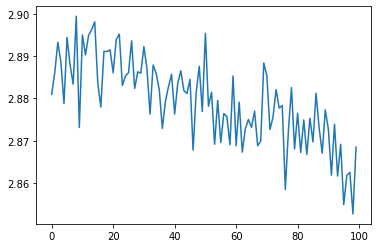

In [287]:
lstm = MultiLayer_LSTM(output_activation, criterion, n_letters, h, n_categories)
losses = lstm.fit(n_iters=10000)
plt.plot(losses)

训练速度较快，loss震荡依然很大，但是已经可以看出下降趋势了，预测结果全是错的，感觉还是训练不足。

#### n_iters = 20000

500 2% (0m 2s) 2.8728 Konstantatos / Japanese ✗ (Greek)
1000 5% (0m 4s) 2.8646 Rubio / Chinese ✗ (Spanish)
1500 7% (0m 7s) 2.8677 Hagiwara / Scottish ✗ (Japanese)
2000 10% (0m 10s) 2.9821 Wawrzaszek / Spanish ✗ (Polish)
2500 12% (0m 12s) 2.8614 Trieu / Japanese ✗ (Vietnamese)
3000 15% (0m 15s) 2.8763 Malouf / Japanese ✗ (Arabic)
3500 17% (0m 17s) 2.9474 Hou / Spanish ✗ (Chinese)
4000 20% (0m 20s) 2.8561 Jia / Spanish ✗ (Chinese)
4500 22% (0m 22s) 2.9460 Treasach / Dutch ✗ (Irish)
5000 25% (0m 25s) 2.7704 Guerrero / Spanish ✓
5500 27% (0m 28s) 2.8022 Drivakis / Spanish ✗ (Greek)
6000 30% (0m 30s) 2.8806 Abboud / Spanish ✗ (Arabic)
6500 32% (0m 33s) 3.0051 Silveira / Spanish ✗ (Portuguese)
7000 35% (0m 35s) 2.9988 O'Malley / French ✗ (Irish)
7500 37% (0m 38s) 2.7892 Maes / Dutch ✓
8000 40% (0m 40s) 2.9068 Ma / Arabic ✗ (Vietnamese)
8500 42% (0m 43s) 2.8434 Doich / Dutch ✗ (Russian)
9000 45% (0m 46s) 2.8482 Hardin / Scottish ✗ (Russian)
9500 47% (0m 48s) 2.8996 Savona / Scottish ✗ (Italia

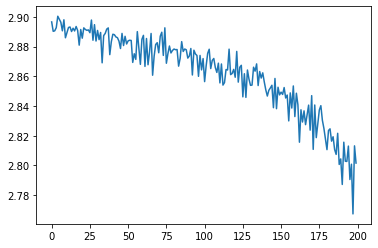

In [288]:
lstm = MultiLayer_LSTM(output_activation, criterion, n_letters, h, n_categories)
losses = lstm.fit(n_iters=20000)
plt.plot(losses)

训练轮次超过15000之后，loss下降开始加快，但是整体下降的也不多。  
感觉可能是批次太小，参数太多，导致训练不足。  
也可能是每次数据都是随机获取一条，部分数据重复使用，另一部分又完全没有用于训练，或者单层的lstm不足以处理这个问题。  
部分预测结果连续预测成同一类，感觉可能是受一些数据影响，把模型带偏了。  

### GRU

In [295]:
class MultiLayer_GRU(nn.Module):
    '''
    多层gru模型
    '''
    def __init__(self, output_activation, criterion, input_size, hidden_size, output_size, num_layers=1):
        '''
        构造函数
        ----------
        output_activation: 输出层激活函数
        criterion： 损失函数
        input_size: 输入维度
        hidden_size: hidden state 和 cell state的维度
        output_size: 输出维度
        num_layers: gru层数
        '''
        super(MultiLayer_GRU, self).__init__()
        self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.output_activation = output_activation # o -> o
        self.criterion = criterion
        self.hidden_size = hidden_size
        
    def forward(self, input, hidden):
        '''
        前向传播
        --------------
        input: 当前时刻的输入
        hidden: 前一时刻的hidden state
        '''
        # 进行前向计算，更新hidden state，获取output
        output, hidden = self.lstm(input, hidden)
        # 将最后的输出尺寸转换成output_size
        output = self.i2o(output[-1])
        # 对输出施加激活
        output = self.output_activation(output)
        return output, hidden

    def initHiddenAndCell(self):
        '''
        全零初始化 0 时刻的 hidden state
        '''
        return torch.zeros(1, 1, self.hidden_size)
    
    def train_single_line(self, category_tensor, line_tensor, learning_rate=0.01):
        '''
        单步训练
        -----------
        category_tensor: label
        line_tensor: data
        learning_rate: 学习率
        '''
        hidden = self.initHiddenAndCell() # 初始化hidden

        self.zero_grad() # 将所有参数的梯度置为零

        # lin_tensor.size() = torch.Size([n, 1, 57])
        output, hidden = self(line_tensor, hidden) # 对输入调用forward，获取输出，hidden state

        # 进行损失计算和反向传播
        loss = self.criterion(output, category_tensor) # 计算损失，传入output和label
        loss.backward() # 自动进行反向传播

        for p in self.parameters():
            # 向负梯度方向更新参数
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item() # 返回最终输出
    
    def fit(self, n_iters = 10000, print_every = 500, plot_every = 100, learning_rate=0.005, lr_decay=None, decay_start=0, verbose=1):
        '''
        训练模型
        -------------
        n_iters: 训练步数
        print_every: 打印过程信息的间隔（lr_decay不为None时，也作为学习率衰减的周期）
        plot_every: 记录平均损失的间隔
        learning_rate: 初始学习率
        lr_decay: 学习率衰减比例(0-1的float)，None为不使用
        verbose: 训练过程是否打印输出
        '''
        # Keep track of losses for plotting
        current_loss = 0
        all_losses = []

        start = time.time() # 初始时间

        for iter in range(1, n_iters + 1):
            category, line, category_tensor, line_tensor = sample_trainning() # 随机生成一条数据
            output, loss = self.train_single_line(category_tensor, line_tensor) # 进行训练
            current_loss += loss # 叠加损失

            if iter % print_every == 0:
                # 打印当前训练结果
                if verbose:
                    guess, guess_i = category_from_output(output)
                    correct = '✓' if guess == category else '✗ (%s)' % category
                    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))
                # 学习率衰减
                if lr_decay and iter > decay_start and lr_decay > 0 and lr_decay < 1:
                    learning_rate *= (1 - lr_decay)

            if iter % plot_every == 0:
                # 记录损失
                all_losses.append(current_loss / plot_every)
                current_loss = 0
        return all_losses

#### 构建网络

In [290]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)
# 选取损失函数
criterion = nn.CrossEntropyLoss()
# 实例化模型
# n_letters = 57
# n_categories = 18
h = 128 # hidden size
gru = MultiLayer_GRU(output_activation, criterion, n_letters, h, n_categories)
# 模型结构
print(gru)

MultiLayer_GRU(
  (lstm): GRU(57, 128)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (output_activation): LogSoftmax()
  (criterion): CrossEntropyLoss()
)


#### 训练 n_iters=1000

500 50% (0m 2s) 2.7418 Ku / Korean ✓
1000 100% (0m 4s) 2.9373 Mccallum / Korean ✗ (Scottish)


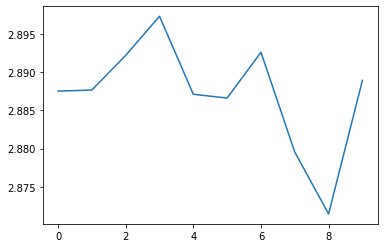

In [291]:
losses = gru.fit(n_iters=1000)
plt.plot(losses)

#### n_iters=10000

500 5% (0m 2s) 2.8425 Soares / Greek ✗ (Portuguese)
1000 10% (0m 4s) 2.8648 Abandonato / Greek ✗ (Italian)
1500 15% (0m 6s) 2.8435 Stenger / Greek ✗ (German)
2000 20% (0m 8s) 2.8606 Diarmaid / Greek ✗ (Irish)
2500 25% (0m 10s) 2.7580 Lachapelle / Greek ✗ (French)
3000 30% (0m 12s) 2.1765 Kokoris / Greek ✓
3500 35% (0m 14s) 2.7040 Fernandez / Spanish ✓
4000 40% (0m 17s) 2.7188 Craig / Scottish ✓
4500 45% (0m 20s) 2.7075 Ozaki / Polish ✗ (Japanese)
5000 50% (0m 22s) 2.9218 Fonseca / Spanish ✗ (Portuguese)
5500 55% (0m 24s) 2.7711 Simpson / English ✗ (Scottish)
6000 60% (0m 27s) 2.3684 Kang / Chinese ✗ (Korean)
6500 65% (0m 29s) 2.3930 Kim / Vietnamese ✓
7000 70% (0m 32s) 2.9978 Plank / Polish ✗ (German)
7500 75% (0m 34s) 3.0906 Logan / Korean ✗ (English)
8000 80% (0m 37s) 1.9990 Lieu / Vietnamese ✓
8500 85% (0m 40s) 2.2391 Olivier / Dutch ✗ (French)
9000 90% (0m 42s) 2.9382 Sleiman / Irish ✗ (Arabic)
9500 95% (0m 45s) 1.1390 Kapsimalles / Greek ✓
10000 100% (0m 47s) 3.0639 Merlo / French

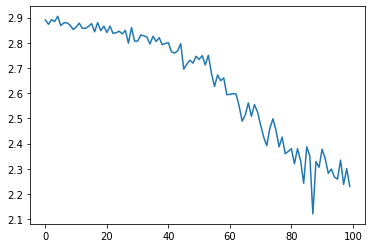

In [292]:
gru = MultiLayer_GRU(output_activation, criterion, n_letters, h, n_categories)
losses = gru.fit(n_iters=10000)
plt.plot(losses)

GRU训练速度比LSTM要快一些，并且在训练10000轮时，loss下降幅度已经超过训练20000轮的LSTM了。

#### n_iters=20000

500 2% (0m 2s) 2.8290 Tron / Portuguese ✗ (Vietnamese)
1000 5% (0m 4s) 2.7533 O'Kelly / Irish ✓
1500 7% (0m 6s) 2.9611 Blades / Japanese ✗ (Greek)
2000 10% (0m 8s) 2.7892 Andel / Irish ✗ (Dutch)
2500 12% (0m 10s) 2.6546 Paulissen / Polish ✗ (Dutch)
3000 15% (0m 12s) 2.8939 Escarra / Dutch ✗ (Spanish)
3500 17% (0m 15s) 2.7328 Bernard / French ✓
4000 20% (0m 17s) 2.6441 Xylander / German ✓
4500 22% (0m 19s) 3.0064 O'Shea / German ✗ (Irish)
5000 25% (0m 22s) 2.8849 Kuai / Polish ✗ (Chinese)
5500 27% (0m 24s) 2.9833 Bonfils / Greek ✗ (French)
6000 30% (0m 27s) 2.7940 Forsythe / Dutch ✗ (English)
6500 32% (0m 30s) 2.7332 Viola / Japanese ✗ (Spanish)
7000 35% (0m 33s) 2.6641 White / Dutch ✗ (Scottish)
7500 37% (0m 36s) 2.8894 Scarsi / Portuguese ✗ (Italian)
8000 40% (0m 38s) 2.6495 Stroud / Spanish ✗ (English)
8500 42% (0m 41s) 2.5108 Caro / Japanese ✗ (Spanish)
9000 45% (0m 44s) 2.9684 Petit / Irish ✗ (Spanish)
9500 47% (0m 46s) 2.3149 Aritza / Japanese ✗ (Spanish)
10000 50% (0m 49s) 2.8234

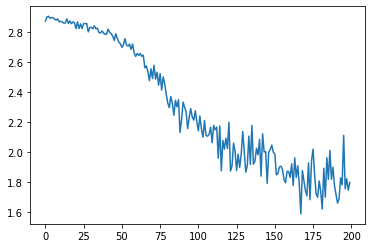

In [293]:
gru = MultiLayer_GRU(output_activation, criterion, n_letters, h, n_categories)
losses = gru.fit(n_iters=20000)
plt.plot(losses)

GRU总体和LSTM差不多，训练速度比LSTM快，因为内部计算比LSTM要少。  
GRU效果要更好一些，不清楚与数据的随机有没有关系，也可能是因为LSTM参数更多，需要的训练轮数也更多。  
在其他参数相同的情况下，20000轮时loss总体下降明显多于LSTM。  
超过11000轮之后震荡幅度加大，可能需要调整learning rate decay。

500 2% (0m 2s) 2.8994 Silveira / Dutch ✗ (Portuguese)
1000 5% (0m 4s) 2.9253 Jollenbeck / Dutch ✗ (German)
1500 7% (0m 6s) 2.9230 Campo / Japanese ✗ (Spanish)
2000 10% (0m 8s) 2.9270 Schlender / Spanish ✗ (German)
2500 12% (0m 9s) 2.7820 Kacy / Spanish ✗ (English)
3000 15% (0m 11s) 2.6990 Snaaijer / French ✗ (Dutch)
3500 17% (0m 13s) 2.4838 Rorris / Greek ✓
4000 20% (0m 15s) 2.8504 Gosden / Irish ✗ (English)
4500 22% (0m 17s) 2.8577 Ly / German ✗ (Vietnamese)
5000 25% (0m 19s) 2.6637 Valenti / Italian ✓
5500 27% (0m 22s) 2.6182 Gong / Chinese ✓
6000 30% (0m 24s) 2.6611 BagaiOol / Greek ✗ (Russian)
6500 32% (0m 26s) 2.3062 Chuhanov / Russian ✓
7000 35% (0m 29s) 2.6449 Zak / Polish ✗ (Czech)
7500 37% (0m 31s) 2.5241 Rakhalsky / Polish ✗ (Russian)
8000 40% (0m 34s) 2.8951 Pereira / Russian ✗ (Portuguese)
8500 42% (0m 37s) 2.2905 Espley / French ✗ (English)
9000 45% (0m 39s) 2.6671 Sze  / Dutch ✗ (Chinese)
9500 47% (0m 42s) 1.6664 Loong / Chinese ✓
10000 50% (0m 44s) 2.1967 Pereira / Portu

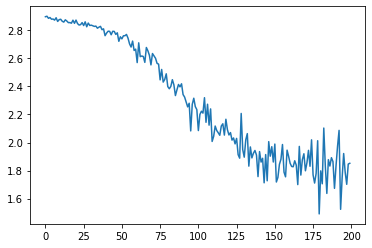

In [297]:
gru = MultiLayer_GRU(output_activation, criterion, n_letters, h, n_categories)
losses = gru.fit(n_iters=20000,lr_decay=0.05, decay_start=11000)
plt.plot(losses)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [298]:
def time_since(since):
    # 计算时间消耗
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### 模型

In [299]:
class Layer(nn.Module):
    '''
    rnn层，包含i2h和i2o两部分
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super(Layer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # (i + h) -> h
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # (i + h) -> o

In [300]:
class MultiLayer_RNN(nn.Module):
    '''
    多层rnn模型
    '''
    def __init__(self, output_activation, criterion):
        '''
        构造函数
        ----------
        output_activation: 输出层激活函数
        criterion： 损失函数
        '''
        super(MultiLayer_RNN, self).__init__()
        self.layers = nn.Sequential()
        self.hidden_activation = nn.Tanh() # 对隐层使用tanh作为激活函数
        self.output_activation = output_activation # o -> o
        self.criterion = criterion

    def add_layer(self, layer_name, input_size, hidden_size, output_size):
        '''
        添加层
        ----------
        layer_name: 该层名称
        input_size: 输入维度
        hidden_size: 隐层维度
        output_size: 输出维度
        '''
        layer = Layer(input_size, hidden_size, output_size)
        self.layers.add_module(layer_name, layer)
        
    def forward(self, input, hidden):
        '''
        前向传播
        --------------
        input: 当前时刻的输入
        hidden: 前一时刻的hidden state列表，长度与layers相同
        '''
        assert(len(hidden) == len(self.layers))
        
        # 初始化上一层的输出
        pre_output = input
        # 遍历各层，进行前向计算，更新hidden state，向下一层传递output
        for i,layer in enumerate(self.layers):
            combined = torch.cat((pre_output, hidden[i]), 1)
            hidden[i] = layer.i2h(combined)
            pre_output = layer.i2o(combined)
            hidden[i] = self.hidden_activation(hidden[i])
            # 除最后一层外，对输出施加tanh激活
            if i < len(self.layers):
                pre_output = self.hidden_activation(pre_output)
        # 对最后的输出施加激活
        output = self.output_activation(pre_output)
        return output, hidden

    def initHidden(self):
        '''
        全零初始化 0 时刻的 hidden state
        '''
        return [torch.zeros(1, layer.hidden_size) for layer in self.layers]
    
    def train_single_line(self, category_tensor, line_tensor, learning_rate=0.005):
        '''
        单步训练
        -----------
        category_tensor: label
        line_tensor: data
        learning_rate: 学习率
        '''
        hidden = self.initHidden() # 初始化hidden state

        self.zero_grad() # 将所有参数的梯度置为零

        for i in range(line_tensor.size()[0]): # torch.Size([n, 1, 57]), range(n)，遍历句子中每个字
            output, hidden = self(line_tensor[i], hidden) # 对每个字调用forward，获取输出，更新hidden state

        # 在一条数据完整输入后，进行损失计算和反向传播
        loss = self.criterion(output, category_tensor) # 计算损失，传入output和label
        loss.backward() # 自动进行反向传播

        # Add parameters' gradients to their values, multiplied by learning rate
        for p in self.parameters():
            # 向负梯度方向更新参数
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item() # 返回最终输出
    
    def fit(self, n_iters = 10000, print_every = 500, plot_every = 100, learning_rate=0.005, lr_decay=None, verbose=1):
        '''
        训练模型
        -------------
        n_iters: 训练步数
        print_every: 打印过程信息的间隔（lr_decay不为None时，也作为学习率衰减的周期）
        plot_every: 记录平均损失的间隔
        learning_rate: 初始学习率
        lr_decay: 学习率衰减比例(0-1的float)，None为不使用
        verbose: 训练过程是否打印输出
        '''
        # Keep track of losses for plotting
        current_loss = 0
        all_losses = []

        start = time.time() # 初始时间

        for iter in range(1, n_iters + 1):
            category, line, category_tensor, line_tensor = sample_trainning() # 随机生成一条数据
            output, loss = self.train_single_line(category_tensor, line_tensor) # 进行训练
            current_loss += loss # 叠加损失

            if iter % print_every == 0:
                # 打印当前训练结果
                if verbose:
                    guess, guess_i = category_from_output(output)
                    correct = '✓' if guess == category else '✗ (%s)' % category
                    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))
                # 学习率衰减
                if lr_decay and lr_decay > 0 and lr_decay < 1:
                    learning_rate *= (1 - lr_decay)

            if iter % plot_every == 0:
                # 记录损失
                all_losses.append(current_loss / plot_every)
                current_loss = 0
        return all_losses
    
    def evaluate(self, line_tensor):
        '''
        调用前向传播，获取结果
        ----------------------
        line_tensor: 输入数据，tensor
        '''
        hidden = self.initHidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)

        return output

    def predict(self, input_line, n_predictions=3):
        '''
        预测，输出概率最高的n项
        ------------------------
        input_line: 输入数据，文本
        n_predictions: 前n项
        '''
        print('\n> %s' % input_line)
        with torch.no_grad(): # 禁用梯度计算
            output = self.evaluate(line_to_tensor(input_line))

            # Get top N categories
            topv, topi = output.topk(n_predictions, 1, True)# 前n项，排序维度，是否从大到小排序
            predictions = []

            # 取出结果并格式化输出
            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))
                predictions.append([value, all_categories[category_index]])

#### 建立模型

In [301]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)
# 选取损失函数
criterion = nn.CrossEntropyLoss()
# 实例化模型
rnn = MultiLayer_RNN(output_activation, criterion)

In [302]:
# 构建多层模型
# n_letters = 57
# n_categories = 18
h_1 = 128 # hidden 1 size
h_2 = 256 # hidden 2 size
h_3 = 128 # hidden 3 size
o_1 = 128 # output 1 size
o_2 = 64  # output 2 size
rnn.add_layer("layer_1", n_letters, h_1, o_1)    # add layer 1 # n_letters -> o_1
rnn.add_layer("layer_2", o_1, h_2, o_2)          # add layer 2 # o_1 -> o_2
rnn.add_layer("layer_3", o_2, h_3, n_categories) # add layer 3 # o_2 -> n_categories

In [303]:
# 模型结构
print(rnn)

MultiLayer_RNN(
  (layers): Sequential(
    (layer_1): Layer(
      (i2h): Linear(in_features=185, out_features=128, bias=True)
      (i2o): Linear(in_features=185, out_features=128, bias=True)
    )
    (layer_2): Layer(
      (i2h): Linear(in_features=384, out_features=256, bias=True)
      (i2o): Linear(in_features=384, out_features=64, bias=True)
    )
    (layer_3): Layer(
      (i2h): Linear(in_features=192, out_features=128, bias=True)
      (i2o): Linear(in_features=192, out_features=18, bias=True)
    )
  )
  (hidden_activation): Tanh()
  (output_activation): LogSoftmax()
  (criterion): CrossEntropyLoss()
)


#### 单步测试

In [304]:
input = letter_to_tensor('A') # 输入数据
hidden = rnn.initHidden() # 初始化hidden state
output, next_hidden = rnn(input, hidden)# 直接调用对象，会调用forward函数

In [305]:
# 输出结果
output

tensor([[-2.9267, -2.9031, -2.9022, -2.9241, -2.9116, -2.8482, -2.8827, -2.8757,
         -2.8552, -2.8891, -2.9105, -2.8546, -2.9141, -2.9450, -2.8166, -2.9492,
         -2.8655, -2.8636]], grad_fn=<LogSoftmaxBackward>)

In [306]:
# 隐层内容
print(len(next_hidden))
print(next_hidden[0].size())
print(next_hidden[1].size())
print(next_hidden[2].size())

3
torch.Size([1, 128])
torch.Size([1, 256])
torch.Size([1, 128])


#### 训练

500 2% (0m 4s) 2.8295 Grenard / Russian ✗ (English)
1000 5% (0m 9s) 2.8201 Tuma / Japanese ✗ (Arabic)
1500 7% (0m 15s) 2.9838 Walentowicz / Russian ✗ (Polish)
2000 10% (0m 20s) 3.0205 Chong / Russian ✗ (Chinese)
2500 12% (0m 26s) 2.8503 Miyamoto / Russian ✗ (Japanese)
3000 15% (0m 31s) 2.9548 Pasternack / French ✗ (Polish)
3500 17% (0m 37s) 2.7211 Zawisza / French ✗ (Polish)
4000 20% (0m 43s) 2.8405 Mooren / Italian ✗ (Dutch)
4500 22% (0m 49s) 2.5708 Yu / Korean ✓
5000 25% (0m 54s) 2.5156 To / Korean ✗ (Vietnamese)
5500 27% (1m 0s) 2.4579 Kourempes / Japanese ✗ (Greek)
6000 30% (1m 5s) 2.5340 Pekhterev / Dutch ✗ (Russian)
6500 32% (1m 10s) 2.7230 Cober / Arabic ✗ (Czech)
7000 35% (1m 16s) 2.5320 Machado / Portuguese ✓
7500 37% (1m 21s) 1.9730 Kui / Chinese ✓
8000 40% (1m 27s) 3.2695 Sitko / Arabic ✗ (Polish)
8500 42% (1m 32s) 2.5386 Dolejsi / Irish ✗ (Czech)
9000 45% (1m 38s) 2.5803 Scordato / French ✗ (Italian)
9500 47% (1m 43s) 2.4916 Urbina / Arabic ✗ (Spanish)
10000 50% (1m 48s) 2.

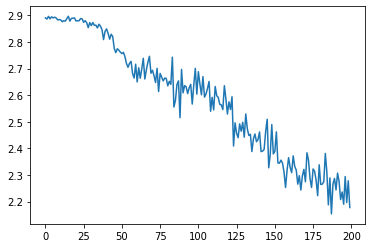

In [307]:
n_iters = 20000
print_every = 500
plot_every = 100

losses = rnn.fit(n_iters, print_every, plot_every,learning_rate=0.01)
plt.plot(losses)

#### 预测

In [308]:
rnn.predict('Dovesky')
rnn.predict('Jackson')
rnn.predict('Satoshi')


> Dovesky
(-1.95) Russian
(-2.11) Polish
(-2.44) English

> Jackson
(-1.83) Russian
(-2.09) Irish
(-2.13) Scottish

> Satoshi
(-1.88) Italian
(-1.97) Polish
(-2.07) Japanese


### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

NLLLoss全称 Negative Log Likelihood Loss，即负log似然损失，需要输入是log变化后的概率，也就是LogSoftmax层输出的形式。  
Softmax后的数值都在0~1之间，所以ln之后值域是负无穷到0。  
NLLLoss的结果就是把log(softmax(logits))中，与Label对应位置的那个值拿出来，去掉负号，再求均值。    

可选参数weight是一个一维的数组，对应各个类别的权重，可以用于类别不均衡的数据集。  

In [234]:
# 选取输出的激活函数
output_activation = nn.LogSoftmax(dim=1)
# 选取损失函数
criterion = nn.NLLLoss()
# 实例化模型
# n_letters = 57
# n_categories = 18
h = 128 # hidden size

500 2% (0m 2s) 2.9598 Ocaskova / Vietnamese ✗ (Czech)
1000 5% (0m 4s) 2.7676 Golofeev / English ✗ (Russian)
1500 7% (0m 6s) 3.0692 Seidel / Russian ✗ (German)
2000 10% (0m 8s) 2.8420 Anderson / Czech ✗ (Scottish)
2500 12% (0m 10s) 2.8621 Rian / Russian ✗ (Irish)
3000 15% (0m 12s) 2.3354 Tsahalis / Greek ✓
3500 17% (0m 15s) 2.8511 Zang / Polish ✗ (Chinese)
4000 20% (0m 17s) 2.8375 Lew / French ✗ (Chinese)
4500 22% (0m 19s) 2.8317 Shum / Vietnamese ✗ (Chinese)
5000 25% (0m 20s) 2.5375 Chuharev / Russian ✓
5500 27% (0m 22s) 2.8609 Taidhg / Vietnamese ✗ (Irish)
6000 30% (0m 24s) 3.1354 Haanraads / Greek ✗ (Dutch)
6500 32% (0m 26s) 2.3553 Zabek / Polish ✓
7000 35% (0m 28s) 2.6961 Salcedo / Portuguese ✗ (Spanish)
7500 37% (0m 30s) 2.6419 Kaiser / Arabic ✗ (German)
8000 40% (0m 33s) 2.4721 Rypka / Japanese ✗ (Czech)
8500 42% (0m 35s) 1.9684 Zavoisky / Russian ✓
9000 45% (0m 37s) 1.7037 Salvai / Italian ✓
9500 47% (0m 40s) 2.9921 Rodrigues / Greek ✗ (Portuguese)
10000 50% (0m 42s) 2.1860 Riche

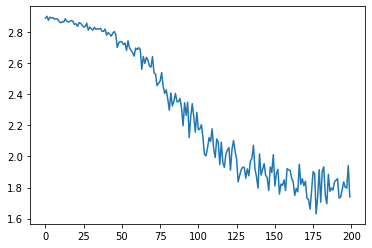

In [309]:
gru = MultiLayer_GRU(output_activation, criterion, n_letters, h, n_categories)
losses = gru.fit(n_iters=20000)
plt.plot(losses)

NLLLoss与CrossEntropyLoss训练结果基本相同。
通过查阅pytorch api发现，交叉熵损失中注有This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class，在NLLLoss的基础上，会执行一次LogSoftmax()，所以在使用交叉熵损失时，不需要先对rnn输出施加激活。  
Reference:  
https://pytorch.org/docs/stable/nn.html#crossentropyloss  
https://pytorch.org/docs/stable/nn.html?highlight=nllloss#torch.nn.NLLLoss

#### NLLLoss

In [332]:
# 随机生成数据
input_ = torch.randn(3,3)
input_

tensor([[-0.1493,  0.1749,  0.1440],
        [-1.1864, -0.9967,  0.2848],
        [-1.3379, -0.7015, -0.7825]])

In [333]:
activation = nn.Softmax(dim=1)
torch.log(activation(input_))

tensor([[-1.3147, -0.9905, -1.0214],
        [-1.8815, -1.6918, -0.4103],
        [-1.5331, -0.8967, -0.9776]])

In [334]:
activation = nn.LogSoftmax(dim=1)
output = activation(input_)
output

tensor([[-1.3147, -0.9905, -1.0214],
        [-1.8815, -1.6918, -0.4103],
        [-1.5331, -0.8967, -0.9776]])

In [337]:
# 假设label为0，2, 1
# 取每行对应值，移除符号，求平均
(abs(output[0][0]) + abs(output[1][2]) + abs(output[2][1])) / 3

tensor(0.8739)

In [348]:
loss = nn.NLLLoss()
label = torch.tensor([0,2,1])
loss(output, label)

tensor(0.8739)

#### CrossEntropyLoss

In [349]:
# 传入未激活值
loss = nn.CrossEntropyLoss()
loss(input_, label)

tensor(0.8739)

In [350]:
# 传入激活值
loss = nn.CrossEntropyLoss()
loss(output, label)

tensor(0.8739)

In [351]:
print(input_)
print(output)

tensor([[-0.1493,  0.1749,  0.1440],
        [-1.1864, -0.9967,  0.2848],
        [-1.3379, -0.7015, -0.7825]])
tensor([[-1.3147, -0.9905, -1.0214],
        [-1.8815, -1.6918, -0.4103],
        [-1.5331, -0.8967, -0.9776]])


传入未激活值和激活值所得的结果一致，说明前面写的网络结构虽然加了激活又用了CrossEntropyLoss，但是结果应该是没有错误的，但是以后工作使用最好注意一下不要多加一层，浪费了计算资源。  
Reference:  
https://blog.csdn.net/qq_22210253/article/details/85229988